# ArcaneGAN

### Transform pictures into Arcane-like images.
This colab script is a rewrite version from [this one](https://colab.research.google.com/drive/1r1hhciakk5wHaUn1eJk7TP58fV9mjy_W)

Original Author: [Alex Sxela](https://github.com/Sxela)

Colab Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/Sxela/ArcaneGAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/ArcaneGAN.ipynb)

In [5]:
#@title Setup

!wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.1/ArcaneGANv0.1.jit
!wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.2/ArcaneGANv0.2.jit
!wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.3/ArcaneGANv0.3.jit
!wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.4/ArcaneGANv0.4.jit

!pip -qq install facenet_pytorch

import os
import PIL
import torch
from torchvision import transforms
from facenet_pytorch import MTCNN


means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
mtcnn = MTCNN(image_size=256, margin=80)


def detect_faces(img):
  # Simple, yet efficient face landmark detection method based on MCTCNN.
  batch_boxes, batch_probs, batch_points = mtcnn.detect(img, landmarks=True)

  # Select faces
  if not mtcnn.keep_all:
    batch_boxes, batch_probs, batch_points = mtcnn.select_boxes(
      batch_boxes, batch_probs, batch_points, img, method=mtcnn.selection_method
    )
  return batch_boxes, batch_points


def make_even(x):
  return x if (x % 2 == 0) else x+1


def scale(
  boxes,
  img,
  max_res=1_500_000,
  target_face=256,
  fixed_ratio=0,
  max_upscale=2,
  VERBOSE=False
):
  x, y = img.size
  ratio = 2 #initial ratio

  # Scale to desired face size
  if boxes is not None and len(boxes) > 0:
    ratio = target_face / max(boxes[0][2:] - boxes[0][:2]); 
    ratio = min(ratio, max_upscale)

  if fixed_ratio > 0:
    ratio = fixed_ratio

  x *= ratio
  y *= ratio

  # Downscale to fit into max_res
  res = x*y
  if res > max_res:
    ratio = pow(res/max_res, 1/2)
    x = int(x / ratio)
    y = int(y / ratio)

  # Make dimensions even number, or the model will fail on uneven dimensions due to the
  # mismatch of skip connection size.
  x = make_even(int(x))
  y = make_even(int(y))
  size = (x, y)
  return img.resize(size)


def scale_by_face_size(
  img,
  max_res=1_500_000,
  target_face=256,
  fix_ratio=0,
  max_upscale=2
):
  boxes, _ = detect_faces(img)
  img_resized = scale(boxes, img, max_res, target_face, fix_ratio, max_upscale)
  return img_resized


def tensor2im(var):
  t_stds = torch.tensor(stds).cuda().half()[:, None, None]
  t_means = torch.tensor(means).cuda().half()[:, None, None]
  return var \
    .mul(t_stds) \
    .add(t_means) \
    .mul(255.) \
    .clamp(0, 255) \
    .permute(1, 2, 0)


def proc_pil_img(input_image, model):
  img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)]
  )
  transformed_image = img_transforms(input_image)[None,...].cuda().half()

  with torch.no_grad():
    result_image = model(transformed_image)[0]
    output_image = tensor2im(result_image)
    output_image = output_image.detach().cpu().numpy().astype('uint8')
    output_image = PIL.Image.fromarray(output_image)
  return output_image

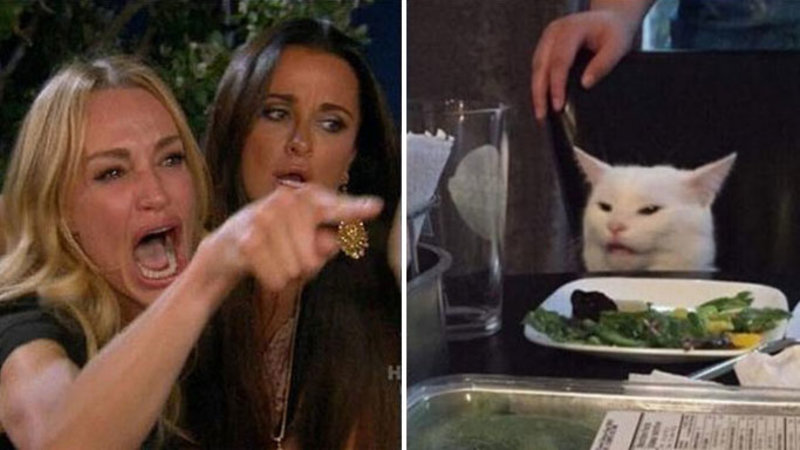

In [3]:
#@title Upload Image

from google.colab import files
from IPython import display as dsp

ff = files.upload()
img_name = list(ff.keys())[0]
dsp.display(dsp.Image(img_name))

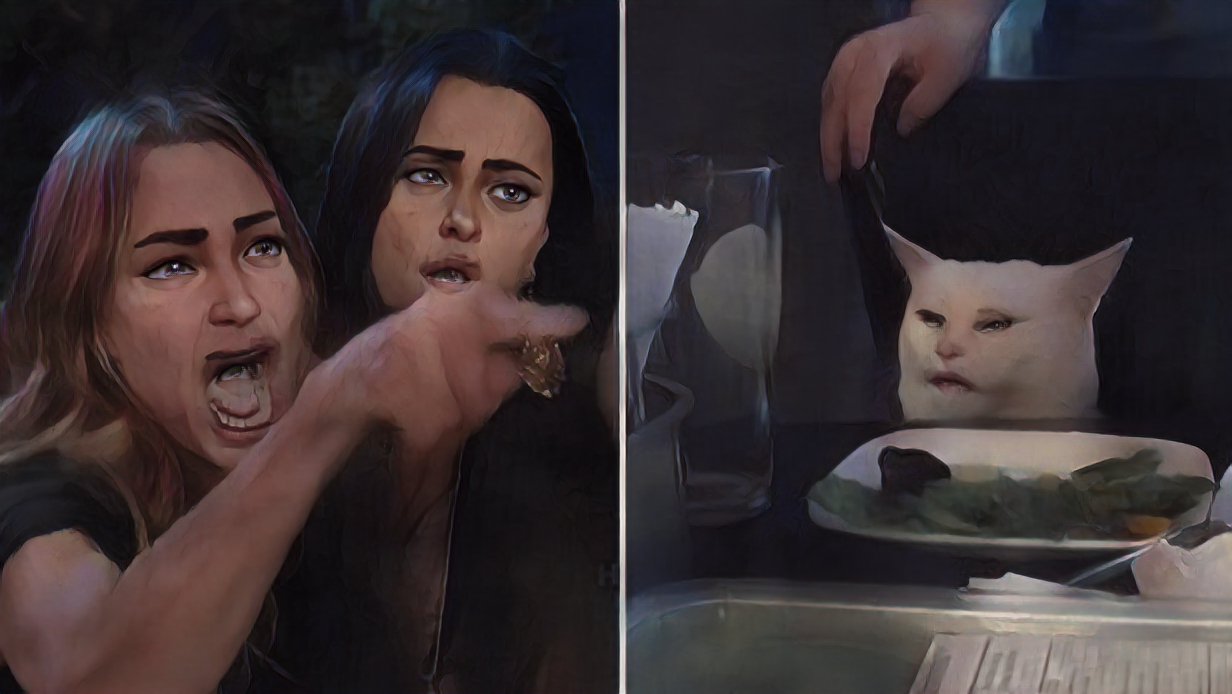

In [6]:
#@title Run

version = '0.4'  #@param ['0.1','0.2','0.3','0.4']
model_path = f'./ArcaneGANv{version}.jit' 
model = torch.jit.load(model_path).eval().cuda().half()

img = PIL.Image.open(img_name).convert("RGB") 
img = scale_by_face_size(img, target_face=300, max_res=1_500_000, max_upscale=2)
res = proc_pil_img(img, model)

basename = os.path.splitext(img_name)[0]
out_name = basename + '_out.png'
res.save(out_name)

dsp.display(res)